from Stats Rethinking

# Hamiltonian Monte Carlo (HMC) – Theoretical Background

## Core Concepts

### 1. **Hamiltonian System**

A physical system can be described using:
- **Position variables** $ q \in R^d $: The parameters we want to sample (e.g., posterior).
- **Momentum variables** $ p \in R^d $: Auxiliary variables introduced to simulate dynamics.

The total energy (Hamiltonian) of the system is defined as:
$H(q, p) = U(q) + K(p)$

where:
- $U(q)$: Potential energy = negative log of the target density (i.e., $ U(q) = -\log \pi(q))$.
- $K(p)$: Kinetic energy = typically $\frac{1}{2} p^T M^{-1} p $ where $ M $ is a mass matrix (usually identity or diagonal).


### 2. **Hamilton’s Equations**

The time evolution of the system is governed by:
$
\frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad \frac{dp}{dt} = -\frac{\partial H}{\partial q}
$

These equations simulate deterministic and reversible dynamics, preserving volume and total energy (up to numerical error).


### 3. **Leapfrog Integrator**

Since exact solutions are often unavailable, we simulate trajectories using the **leapfrog integrator**, which has the following properties:
- Time-reversible
- Volume-preserving
- Approximate energy conservation

Leapfrog steps (with step size $ \epsilon $):

1. Half-step momentum update:
$
   p \leftarrow p - \frac{\epsilon}{2} \nabla U(q)
$
2. Full-step position update:
$
   q \leftarrow q + \epsilon M^{-1} p
$


These are repeated $ L $ times to simulate the trajectory.


### 4. **Metropolis Correction**

After simulating a new state $ (q^*, p^*) $, we perform a Metropolis–Hastings step to correct for discretization error:

$
\text{accept with probability } \min\left(1, \exp\left(H(q, p) - H(q^*, p^*)\right)\right)
$

If accepted, we move to $ q^* $; otherwise, we stay at $ q $.


## Why HMC Works

- **Avoids Random Walks**: Instead of local, diffusive proposals, HMC follows long, informed paths.
- **Efficient in High Dimensions**: Gradient information helps explore parameter space more effectively.
- **Low Autocorrelation**: Leads to faster convergence and better effective sample size.


## Parameters to Tune

- **Step size $ \epsilon $**: Too large leads to low acceptance; too small leads to slow exploration.
- **Number of leapfrog steps $ L $**: Longer trajectories explore more but are more computationally expensive.
- **Mass matrix $ M $**: Can be tuned or adapted for better performance (especially with correlated parameters).

> ⚠️ Poorly tuned HMC can still perform poorly. Adaptive methods like **NUTS (No-U-Turn Sampler)** help automate this.


## Summary

| Component        | Role                                   |
|------------------|----------------------------------------|
| $ q $          | Parameters to infer (position)         |
| $ p $          | Auxiliary momentum variables           |
| $ U(q) $       | Potential energy (−log target density) |
| $ K(p) $       | Kinetic energy (Gaussian typically)    |
| Leapfrog         | Numerical integrator for simulation    |
| Metropolis step  | Ensures correct stationary distribution|



## 🔍 Interpreting the Hamiltonian and Role of Data in HMC (MCMC)

Hamiltonian Monte Carlo (HMC) is an MCMC method designed to efficiently sample from a posterior distribution. Here's how the **Hamiltonian** relates to the **posterior probability** and where **data** is used in the process.

### 🧠 Conceptual Mapping

In Bayesian inference, we want to sample from the **posterior**:

$$
p(\theta \mid \mathcal{D}) \propto p(\mathcal{D} \mid \theta) \, p(\theta)
$$

- $\theta$: parameters to estimate
- $\mathcal{D}$: observed data
- $p(\mathcal{D} \mid \theta)$: likelihood (data is here)
- $p(\theta)$: prior
- $p(\theta \mid \mathcal{D})$: posterior

### ⚙️ Hamiltonian in HMC

HMC introduces a **Hamiltonian function** combining parameter position $\theta$ and auxiliary momentum variables $r$:

$$
H(\theta, r) = U(\theta) + K(r)
$$

- $U(\theta)$: potential energy (negative log posterior)
- $K(r)$: kinetic energy (typically Gaussian, e.g., $\frac{1}{2} r^T M^{-1} r$)

### 📌 Step-by-Step Breakdown

#### 1. **Potential Energy $U(\theta)$**

This is the **negative log-posterior**, which incorporates **data**:

$$
U(\theta) = -\log p(\theta \mid \mathcal{D}) = -\log p(\mathcal{D} \mid \theta) - \log p(\theta)
$$

➡️ **Data is used here**, in computing the likelihood term $-\log p(\mathcal{D} \mid \theta)$.

#### 2. **Gradient of $U(\theta)$**

The gradient of the potential energy is used to simulate the dynamics:

$$
\nabla_\theta U(\theta) = -\nabla_\theta \log p(\mathcal{D} \mid \theta) - \nabla_\theta \log p(\theta)
$$

➡️ **Data is also used here** in computing the gradient of the log-likelihood.

#### 3. **Leapfrog Integration**

Leapfrog steps use the gradient $\nabla_\theta U(\theta)$ to simulate the Hamiltonian dynamics:

- Position $\theta$ and momentum $r$ are updated over small steps.
- This allows for efficient exploration of the posterior space.

➡️ **Indirect use of data**, as it's required for computing the gradient.


#### 4. **Metropolis-Hastings Acceptance**

After simulating a trajectory, we accept or reject the proposal based on:

$$
\min\left(1, \exp\left[H(\theta, r) - H(\theta', r')\right] \right)
$$

➡️ Again, this requires evaluating $U(\theta)$, which includes the **log-likelihood from the data**.


### 🔁 Summary of Where Data Is Used

| Step | Description | Data Used? |
|------|-------------|------------|
| 1 | Compute $U(\theta)$ | ✅ Yes, in $-\log p(\mathcal{D} \mid \theta)$ |
| 2 | Compute $\nabla U(\theta)$ | ✅ Yes, in $-\nabla_\theta \log p(\mathcal{D} \mid \theta)$ |
| 3 | Leapfrog Integration | ⚠️ Indirectly, via gradients |
| 4 | Metropolis-Hastings Acceptance | ✅ Yes, in computing $H(\theta, r)$ |



Acceptance rate: 0.98


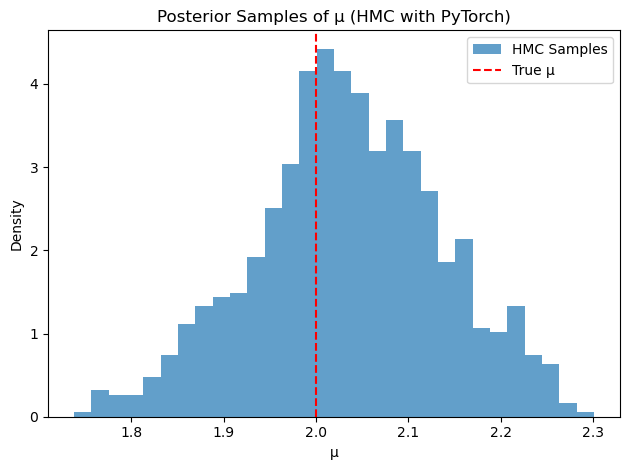

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set float precision and device
dtype = torch.float32
device = torch.device("cpu")

# ---------------------
# 1. Generate synthetic data
# ---------------------
torch.manual_seed(0)
true_mu = 2.0
sigma = 1.0
n_samples = 100
data = torch.normal(true_mu, sigma, size=(n_samples,))

# ---------------------
# 2. Log posterior and gradient
# ---------------------
def log_posterior(mu, data):
    # Prior: mu ~ N(0, 5^2)
    log_prior = -0.5 * ((mu / 5)**2 + np.log(2 * np.pi * 25))
    # Likelihood: y_i ~ N(mu, sigma^2)
    log_likelihood = -0.5 * torch.sum(((data - mu)/sigma)**2 + np.log(2 * np.pi * sigma**2))
    return log_prior + log_likelihood

def potential_energy(mu):
    return -log_posterior(mu, data)

# ---------------------
# 3. HMC Step using Leapfrog
# ---------------------
def hmc_step(current_mu, epsilon, L, mass=1.0):
    # Detach and set requires_grad for autograd
    mu = current_mu.clone().detach().requires_grad_(True)
    p = torch.randn_like(mu) * mass  # Sample momentum

    current_U = potential_energy(mu)
    current_K = torch.sum(p**2) / (2 * mass)

    # Make a copy of p for leapfrog
    p_half = p.clone()

    # 1. Half step for momentum
    current_U.backward()
    p_half = p_half - (epsilon / 2) * mu.grad
    mu.grad.zero_()

    # 2. Full steps
    for i in range(L):
        mu = (mu + epsilon * p_half / mass).detach().requires_grad_(True)

        potential = potential_energy(mu)
        potential.backward()
        if i != L - 1:
            p_half = p_half - epsilon * mu.grad
            mu.grad.zero_()

    # 3. Final half step
    p_half = p_half - (epsilon / 2) * mu.grad
    mu.grad.zero_()

    # Negate momentum for symmetry
    p_half = -p_half

    # Compute Hamiltonians
    proposed_U = potential_energy(mu)
    proposed_K = torch.sum(p_half**2) / (2 * mass)

    acceptance_prob = torch.exp(current_U + current_K - proposed_U - proposed_K)
    if torch.rand(1) < acceptance_prob:
        return mu.detach(), True
    else:
        return current_mu.detach(), False

# ---------------------
# 4. Run HMC sampler
# ---------------------
num_samples = 1000
burn_in = 200
epsilon = 0.05
L = 20

samples = []
accepted = 0

mu = torch.tensor([0.0], dtype=dtype)

for i in range(num_samples + burn_in):
    mu, acc = hmc_step(mu, epsilon, L)
    if i >= burn_in:
        samples.append(mu.item())
    if acc:
        accepted += 1

samples = np.array(samples)
print(f"Acceptance rate: {accepted / (num_samples + burn_in):.2f}")

# ---------------------
# 5. Plot results
# ---------------------
plt.hist(samples, bins=30, density=True, alpha=0.7, label="HMC Samples")
plt.axvline(true_mu, color='red', linestyle='--', label="True μ")
plt.title("Posterior Samples of μ (HMC with PyTorch)")
plt.xlabel("μ")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
